In [3]:
%matplotlib widget
from i_o import Paths
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os, glob, h5py
import importlib, pathlib
from daio.h5 import lazyh5
from video import create_projection_image, showvid, get_clipped_array

import warpfield
from IPython.display import JSON
import pandas as pd
from widgets import OrthoViewsWidget


In [4]:
pn_psfs = r"~/hpc-rw/lfm/psfs"
pn_rec = r"~/hpc-r/lfm2025/recordings"
pn_bg = r"~/hpc-rw/lfm/bg"
url_home = r"/home/lubo12/"
pn_out = r"~/hpc-rw/lfm/results"


# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1358_LB_ZF_v552_f1_40fps_2/registered.h5" 
# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1501_LB_ZF_v552_f3_40fps_2/registered.h5"
# fn = "/home/lubo12/hpc-rw/lfm/results/20250701_1538_LB_ZF_v552_f5_40fps_1/registered.h5"

dataset_name = "20250701_1501_LB_ZF_v552_f3_40fps_2"
psf_name = "20250701_1216_PSF_LB_noap_1"
bg_name = "20250701_1651_LB_bg_40fps.npy"
# bg_name = "20250701_1649_LB_bg_80fps.npy"

import i_o
importlib.reload(i_o)
from i_o import Paths

paths = Paths(dataset_name=dataset_name,
              psf_name = psf_name,
              bg_name=bg_name,
              pn_bg= pn_bg,
              pn_rec = pn_rec,
              pn_psfs=pn_psfs,
              pn_out=pn_out,
              url_home=url_home,)

In [5]:
reg=lazyh5(paths.registered)

reg

<IPython.core.display.JSON object>

In [6]:
cov_map_f = dogfilter_gpu(reg["cov_map"], sigma_low = [1.5,0.5,0.5], sigma_high = [4,4,4])
OrthoViewsWidget(get_clipped_array(cov_map_f.transpose(0,2,1), vmax=10).get())

OrthoViewsWidget(coords=[72, 128, 400], sar=[1.0, 1.0, 1.0], src=['data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACA…

(1112,) 20250701_1501_LB_ZF_v552_f3_40fps_2


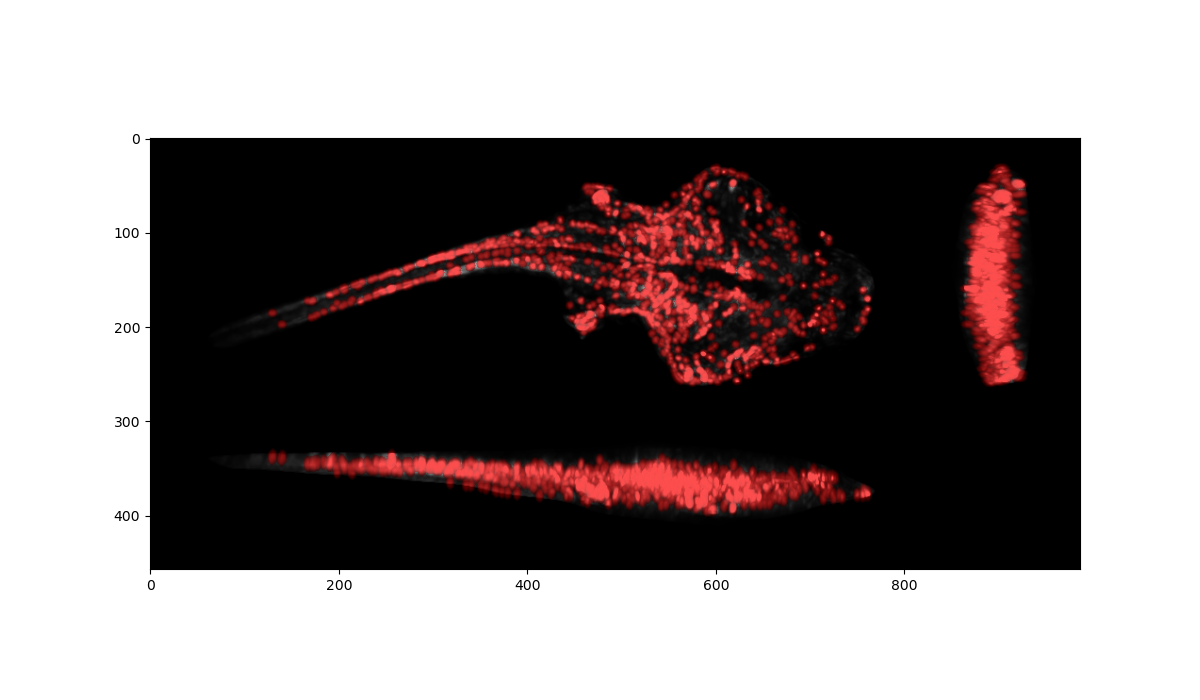

In [7]:
import signal_extraction
importlib.reload(signal_extraction)
from signal_extraction import dogfilter_gpu, findmaxima_gpu, soft_ball, create_projection_image_with_peaks, save_segmentation_result_tif

min_search_radius=[1,1,1]
min_peak_brightness = 0.003
softball_shape = [6,3.5,3.5]
softball_k = 2

# cov_map_f = dogfilter_gpu(reg["cov_map"], sigma_low = [0.5,0.5,0.5], sigma_high = [4,4,4])
maxima_bool, peaks, peak_vals = findmaxima_gpu(cov_map_f, radius = min_search_radius, thresh = min_peak_brightness)
softball_kernel = cp.array(soft_ball(softball_shape, k=softball_k), 'float32')
softball_kernel /= softball_kernel.sum()

fig, ax = plt.subplots(1,1,figsize=(12,7))
# n=4
# peaks_subset= (peaks[0][2::n],peaks[1][2::n],peaks[2][2::n])
ax.imshow(create_projection_image_with_peaks(reg["cov_map"], peaks, vmax=5, marker_radius = softball_shape, marker_k = softball_k, marker_intensity=0.8, transpose= True))
rgb = save_segmentation_result_tif(reg["cov_map"], peaks, output_fn = os.path.expanduser("test.tif"), marker_radius=softball_shape,marker_k=softball_k,vmax=2*min_peak_brightness) #os.path.expanduser(os.path.join(paths.pn_outrec,"segmentation.tif"))
# tifffile.imwrite("test.tif", rgb.get(), imagej=True)
print(peaks[0].shape, paths.dataset_name)

In [10]:
os.path.exists(os.path.expanduser("test.tif"))


True

In [93]:
from i_o import VolumeReader
import cupyx
reader = VolumeReader(paths.registered, "data")

traces = []
for i_frame,vol in tqdm(reader):
    vol = cupyx.scipy.ndimage.convolve(cp.asarray(vol), softball_kernel) 
    traces.append(vol[peaks].get())
traces = np.array(traces).T

KeyboardInterrupt: 

(1.5, 5.5)

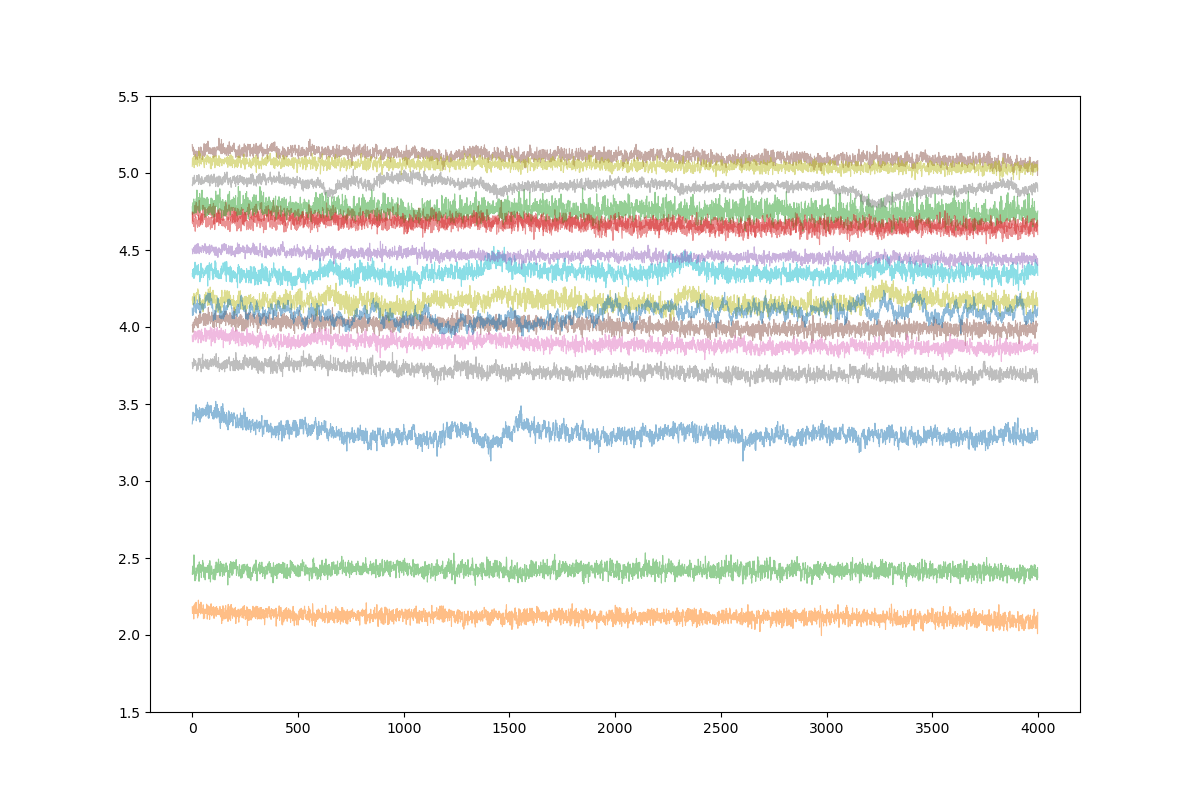

In [96]:
from util import plot_traces
# idx = np.random.choice(np.arange(traces.shape[0]), 20)
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_traces(traces[idx,:4000].T, np.ones(shape=[4000]), n=20,ax=ax, scale_factor = 0.2, y_add = 1)
ax.set_ylim(1.5,5.5)

In [ ]:
    register_result = io.load_from_h5(paths.register_result)
    cov_map_f = warp.dogfilter_gpu(cp.array(register_result['cov_map']), sigma_low=sigma_low, sigma_high=sigma_high)
    min_radius = np.array(min_radius_um) / register_result['reg']['px_sz_bin']
    maxima_bool, peaks, peak_vals = segment.findmaxima_gpu(cov_map_f, min_radius)
    indices = cp.array(peaks).get()
    coords = indices * register_result['reg']['px_sz_bin'][:, None]
    rvr = registered_volume_reader(paths, reg_res=register_result)

    # videos
    if make_ortho_vid:
        ortho_video = video.OrthoVideo(paths.maxproj_vid + '_trace_extract.mp4',
                                       register_result['cov_map'],
                                       register_result['reg']['px_sz_bin'],
                                       umperpix=2,
                                       proj_method=register_result['reg']['vid_proj_method'],
                                       vmin=register_result['reg']['vid_vmin'],
                                       vmax=register_result['reg']['vid_vmax'])

    if make_montage_vid:
        n = 7**3  # number of trace coords
        best = cp.argsort(peak_vals)[-20000:]
        block_coords = cp.random.permutation(cp.array(peaks)[:, best].T).T[:, :n].astype(int)
        umperpix = register_result['reg']['px_sz_bin'].min()
        montage_video = video.MontageVideo(paths.maxproj_vid + '_trace_montage.mp4',
                                           register_result['cov_map'],
                                           register_result['reg']['px_sz_bin'],
                                           umperpix=umperpix,
                                           proj_method=register_result['reg']['vid_proj_method'],
                                           vmin=register_result['reg']['vid_vmin'],
                                           vmax=register_result['reg']['vid_vmax'],
                                           block_coords=block_coords,
                                           block_um=[12, 12, 12],
                                           add_overview=True)

    soft_ball_kernel = cp.array(segment.soft_ball(softballradius / register_result['reg']['px_sz_bin'], k=softball_k), 'float32')
    soft_ball_kernel /= soft_ball_kernel.sum()

    traces = []
    for i_frame, vol in tqdm(rvr, desc='traces'):
        vol *= gain_corr
        vol = cupyx.scipy.ndimage.convolve(vol, soft_ball_kernel)  # soft_ball convolution

        traces.append(vol[peaks].get())
        if make_ortho_vid:
            ortho_video.step(vol, i_frame)
        if make_montage_vid:
            montage_video.step(vol, i_frame)

    if make_ortho_vid:
        ortho_video.close()
    if make_montage_vid:
        montage_video.close()

    traces_results = dict(
        coords=coords,
        traces=np.array(traces),
        cov_vals=peak_vals.get(),
        indices=indices,
        dataset_name=paths.dataset_name,
        reg=register_result['reg'],
        rs=register_result['rs'],
        timestamp=io.timestamp(),
        code_version=io.code_version(),
    )
    if save:
        io.save_to_h5(paths.traces[:-3]+f"_gaincorr{gain_corr}.h5", traces_results, compression=hdf5plugin.Zstd())
    return traces_results